# TP1:Méthodes traditionnelles de calcul de la VaR et Expected Shortfall

(ES)

Ce TP est fait dans le but de modéliser la Value at Risk qui est une
mesure de risque financier. La Value at Risk (VaR) est une mesure
essentielle du risque de marché qui estime la perte potentielle maximale
d’un portefeuille sur un horizon h donné, avec un certain niveau de
confiance $\alpha$. La VaR est utilisée par les institutions financières
et les gestionnaires de risques pour évaluer l’exposition aux pertes
extrêmes et ajuster leurs stratégies d’investissement. Elle est définie
comme suit :

$$VaR_{\alpha}(h) = inf \{ l \in \mathbb{R} | P(PnL \geq -l) \geq 1 - \alpha \}$$

Le PnL représente le profit and loss, c’est-à-dire la variation de la
valeur du portefeuille. Dans notre cas, nous utilserons les rendements
logarithmiques des actifs financiers, qui est stationnaire, pour
calculer la VaR. Les rendements logarithmiques sont calculés comme suit
:

$$r_t = log(\frac{P_t}{P_{t-1}}) \approx \frac{P_t - P_{t-1}}{P_{t-1}}.$$

Cette mesure est préférée aux rendements simples car sa décomposition en
termes additifs permet de mieux modéliser les variations de prix des
actifs financiers. De plus, en supposant la distribution identique et
indépendante des rendements, on peut facilement déterminer sa loi de
probabilité et calculer la VaR.

Dans ce projet, nous explorerons plusieurs méthodes pour calculer la
VaR, en tenant compte de la nature des rendements financiers et des
hypothèses sous-jacentes :

-   **Méthodes non paramétriques** : VaR historique et VaR bootstrap.
-   **Méthodes paramétriques**: VaR gaussienne et VaR basée sur une
    distribution Skew Student.
-   **Méthodes avancées** : VaR avec pondération exponentielle EWMA et
    VaR calculée par diffusion d’actifs. En complément, nous calculerons
    également l’Expected Shortfall (ES), qui mesure la perte moyenne
    au-delà du seuil de la VaR. Cette mesure est plus robuste, car elle
    intègre les queues de distribution et est particulièrement utile
    pour évaluer les risques extrêmes.

In [2]:
# Définition des librairies
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm
from scipy.stats import bootstrap

warnings.filterwarnings("ignore")

/Users/cherylkouadio/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning:

urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020


In [3]:
# Import des données du CAC 40
data = yf.download("^FCHI")

YF.download() has changed argument auto_adjust default to True

[*********************100%***********************]  1 of 1 completed

In [4]:
# Calcul des rendements logarithmiques
data['log_return'] = np.log(data['Close'] / data['Close'].shift(1))

# Retirer la première ligne
data = data.dropna()

In [5]:
data.head()

# I. Data wrangling

Le jeu de données est constitué de 6 variables, à savoir, le prix de
clôture (Close), le volume des transactions (Volume), le prix
d’ouverture (Open), le prix le plus bas (Low), le prix le plus élevé
(High) et les rendements logarithmiques (log-return). Pour calculer les
rendements sur lesquels nous nous sommes baser pour mesurer le risque du
portefeuille, nous avons utilisé le prix de clôture. Il aurait été idéal
de disposer des prix de clôture ajustés, i.e. les prix de clôture qui
tiennent compte des dividendes et des éventuels splits. Cependant, en
raison de l’indispobilité de ces données, nous avons utilisé les prix de
clôture bruts.

Sur tout l’historique du CAC 40, nous n’observons aucune donnée
manquante et aucune valeur aberrante (i.e. Prix de clôture négatif).
Nous avons donc pu calculer les rendements logarithmiques sans problème.

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8893 entries, 1990-03-02 to 2025-03-10
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   (Close, ^FCHI)   8893 non-null   float64
 1   (High, ^FCHI)    8893 non-null   float64
 2   (Low, ^FCHI)     8893 non-null   float64
 3   (Open, ^FCHI)    8893 non-null   float64
 4   (Volume, ^FCHI)  8893 non-null   int64  
 5   (log_return, )   8893 non-null   float64
dtypes: float64(5), int64(1)
memory usage: 486.3 KB

In [7]:
data.describe()

In [8]:
# check na
print("="*80)
print(data.isna().sum())
print("="*80)

Price       Ticker
Close       ^FCHI     0
High        ^FCHI     0
Low         ^FCHI     0
Open        ^FCHI     0
Volume      ^FCHI     0
log_return            0
dtype: int64

Sur tout l’historique du CAC40, i.e. entre 1990 jusqu’à récemment, nous
avons enregistré 5 périodes de crise financière. Ces périodes sont les
suivantes :

-   1994 : Crise obligataire
-   2000 : Bulle Internet
-   2008 : Crise des subprimes
-   2011 : Crise de la dette souveraine
-   2020 : Crise du Covid-19

Cela peut se réperer par les clusters de rendements observables sur le
graphique ci-dessous. Comme on peut l’observer, ces clusters de
volatilité sont généralement associés à des périodes où le rendement
journalier chute brutalemment. Pour mesurer le risque de marché, il peut
être utile de modéliser ces clusters de volatilité et de prendre en
compte les queues de distribution à travers des modèles GARCH par
exemple.

Pour modéliser la VaR comme mesure de risque, il serait utile également
de prendre les événements extrêmes en considération. En effet, en
observant la densité des rendements, on peut voir que la distribution
des rendements est leptokurtique, c’est-à-dire que les queues de
distribution sont plus épaisses que celles d’une distribution normale
(kurtosis \> 3). Cela signifie que les événements extrêmes sont plus
fréquents que ce que la distribution normale ne le suggère. De plus, le
coefficient d’asytmmétrie est négatif, ce qui signifie que la
distribution des rendements est asymétrique. Cela peut être
problématique pour les méthodes paramétriques qui supposent, parfois,
une distribution symétrique des rendements.

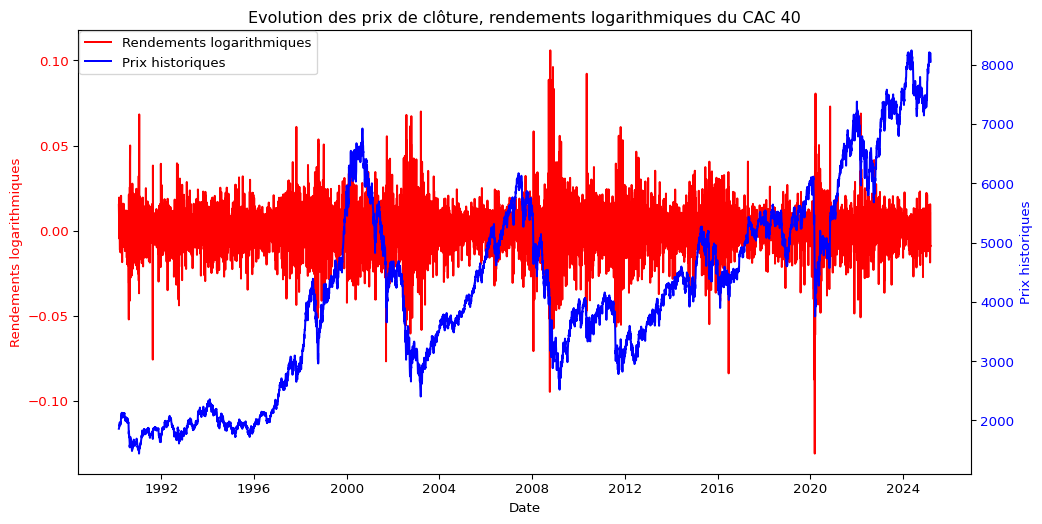

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.plot(data['log_return'], label='Rendements logarithmiques', color='red')
ax1.set_xlabel('Date')
ax1.set_ylabel('Rendements logarithmiques', color='red')
ax1.tick_params(axis='y', labelcolor='red')

ax2 = ax1.twinx()
ax2.plot(data['Close'], label='Prix historiques', color='blue')
ax2.set_ylabel('Prix historiques', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

fig.legend(loc='upper left', bbox_to_anchor=(0.12,0.89))
plt.title("Evolution des prix de clôture, rendements logarithmiques du CAC 40")
plt.show()

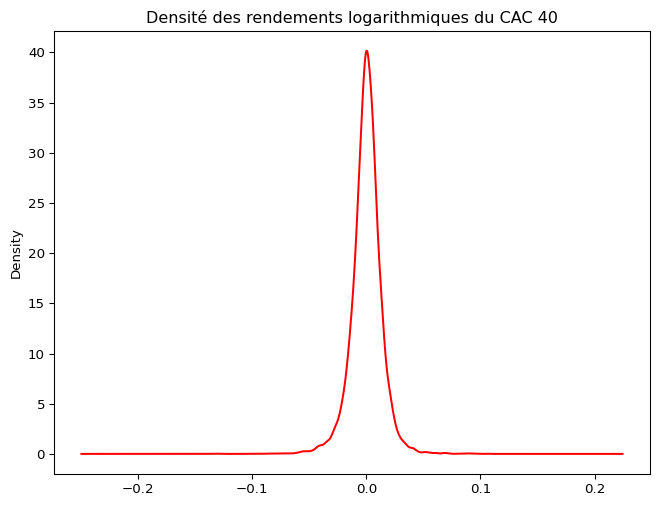

In [10]:
# Densité des rendements logarithmiques
plt.figure(figsize=(8, 6))
data['log_return'].plot(kind='kde', color='red')
plt.title("Densité des rendements logarithmiques du CAC 40")
plt.show()

In [11]:
# Skewness
skewness = data['log_return'].skew()
print(f"Skewness: {skewness:.2f}")

# Kurtosis
kurtosis = data['log_return'].kurtosis()
print(f"Kurtosis: {kurtosis:.2f}")

Skewness: -0.20
Kurtosis: 5.90

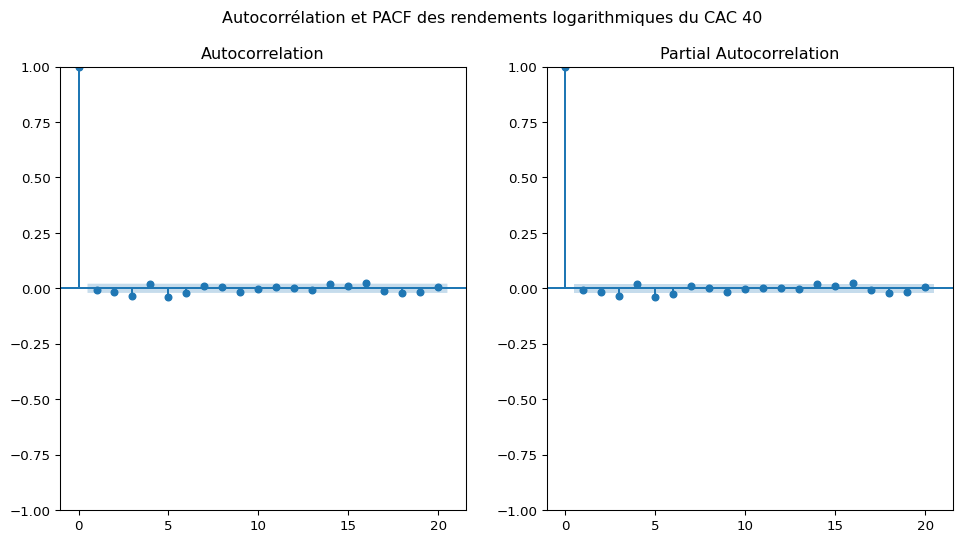

In [12]:
# Autocorrélation et pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

plot_acf(data['log_return'], lags=20, ax=ax1)
plot_pacf(data['log_return'], lags=20, ax=ax2)

plt.suptitle("Autocorrélation et PACF des rendements logarithmiques du CAC 40")
plt.show()

In [13]:
# check for stationarity
from statsmodels.tsa.stattools import adfuller
import pandas as pd

def adf_test(series, title=''):
    """
    Pass in a time series and an optional title, returns an Adataset report
    """
    print('Augmented Dickey-Fuller Test: {}\n'.format(title))
    # .dropna() handles differenced data
    result = adfuller(series.dropna(),autolag='AIC')

    labels = ['Adataset test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)

    for key,val in result[4].items():
        out['critical value ({})'.format(key)]=val

    # .to_string() removes the line "dtype: float64"
    print(f'{out.to_string()}\n')

    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

print("="*80)
adf_test(data["Close"], title='Prix de clôture')
print("="*80)
adf_test(data["log_return"], title='Log-rendements')
print("="*80)

Augmented Dickey-Fuller Test: Prix de clôture

Adataset test statistic      -0.873878
p-value                       0.796453
# lags used                  30.000000
# observations             8862.000000
critical value (1%)          -3.431088
critical value (5%)          -2.861866
critical value (10%)         -2.566944

Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
Augmented Dickey-Fuller Test: Log-rendements

Adataset test statistic     -41.273429
p-value                       0.000000
# lags used                   5.000000
# observations             8887.000000
critical value (1%)          -3.431086
critical value (5%)          -2.861865
critical value (10%)         -2.566943

Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary

# II. Implémentation de la VaR

On va prendre comme période d’apprentissage où la BCE fait baisser ses
taux directeurs et comme période de (back-)test où la BCE fait augmenter
ses taux directeurs. De ce fait, nous avons le découpage suivant : -
Train : 15 octobre 2008 - 26 juillet 2022 - Test : 28 juillet 2022 - 11
juin 2024

On va implémenter les différentes méthodes de calcul de la VaR et de
l’ES sur le jeu de données du CAC 40. On va comparer les performances de
ces méthodes en utilisant la période de test. On s’attend à ce que les
méthodes paramétriques soient moins performantes que les méthodes non
paramétriques, car elles supposent une distribution des rendements qui
n’est pas toujours vérifiée. De plus, les méthodes avancées, comme
l’EWMA et la diffusion d’actifs, devraient être plus performantes que
les méthodes non paramétriques, car elles prennent en compte la
dynamique des rendements et les corrélations entre les actifs. En
général, le backtest devrait être vérifié puisque la période de test ne
comporte aucune crise financière.

In [14]:
train = data[['log_return',"Close"]]['15-10-2008':'26-07-2022']
data_train = train['log_return']

test = data[['log_return',"Close"]]['27-07-2022':'11-06-2024']
data_test = test['log_return']

## II.1. Statistiques descriptives

Nous constatons que dans la période d’entrainement est plus volatile
(std=1.39%). Cela s’explique par le fait que la période d’entrainement
prend en compte deux crises majeures : la crise des subprimes et la
crise du Covid-19. Cela peut également se voir à travers les clusters de
volatilité observables à la suite de ces crises. Dans la période de
test, aucun évènement majeur n’est observé, avec une plus faible
volatilité observée (std=0.08%).

On s’attend à ce que la VaR entrainée sur la période d’entrainement
performe très bien sur la période de test, mais on s’attend également à
ce que la VaR entrainée sur la période de test performe moins bien sur
la période d’entrainement.

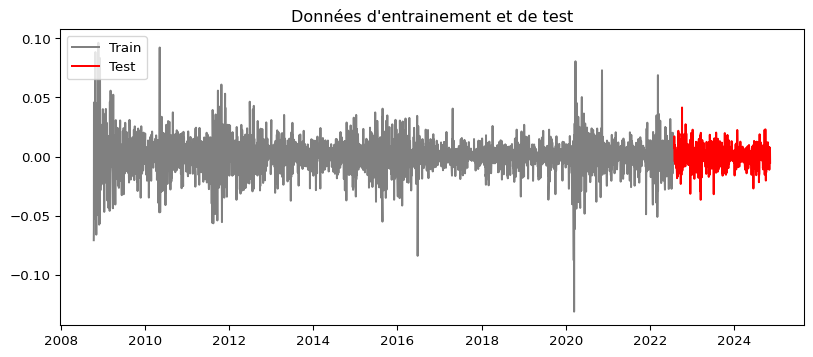

In [15]:
plt.figure(figsize=(10, 4))
plt.plot(data_train, label='Train', color='grey')
plt.plot(data_test, label='Test', color='red')
plt.legend(loc='upper left')
plt.title("Données d'entrainement et de test")
plt.show()

In [16]:
data_train.describe()

count    3523.000000
mean        0.000153
std         0.013953
min        -0.130983
25%        -0.006099
50%         0.000580
75%         0.006855
max         0.096169
Name: log_return, dtype: float64

In [17]:
data_test.describe()

count    586.000000
mean       0.000292
std        0.008947
min       -0.036484
25%       -0.004763
50%        0.000642
75%        0.005612
max        0.041504
Name: log_return, dtype: float64

## II.2. VaR non paramétrique

La VaR est une mesure de risque qui donne une estimation de la perte
maximale que l’on peut subir avec un certain niveau de confiance
$\alpha$ sur un horizon de temps donné. Par exemple, une VaR à 5% sur 1
jour de 1000 euros signifie que 95% du temps, on ne perdra pas plus de
1000 euros sur un jour.

$$P(\text{Loss} < \text{VaR}) = \alpha.$$

On peut également raisonner en terme de gain, i.e. Profit and Loss
(PnL).

$$P(\text{PnL} > - \text{VaR}) = \alpha.$$

La VaR peut se calculer suivant trois approches : 1. **Approche
historique** : On se base sur les rendements passés selon l’horizon fixé
pour estimer la VaR, à l’aide d’un quantile empirique d’ordre $\alpha$.
Autrement, on peut se baser sur les rendements journaliers et utiliser
la méthode de **scaling**. 2. **Approche bootstrap** : On tire
aléatoirement des échantillons de rendements passés avec remise, puis on
prend le quantile empirique d’ordre $\alpha$ pour calculer la VaR de
chaque échantillon. La VaR finale est la moyenne des VaR obtenues.

### II.2.1. Historique

In [18]:
# Objectif : implémenter une fonction calculant la VaR historique

def historical_var(data, alpha=0.99):
    """
    Calcul de la VaR historique
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    """
    return -np.percentile(data, 100*(1- alpha))

In [19]:
# Calcul de la VaR historique sur l'échantillon d'entrainement pour h=1j et alpha=0.99
alpha = 0.99
var_hist_train = historical_var(data_train, alpha=alpha)
print(f"La VaR historique pour h=1j et alpha=0.99 est : {var_hist_train:.4%}")

La VaR historique pour h=1j et alpha=0.99 est : 4.0850%

On constate que la VaR historique pour une horizon de 1 jour et un
niveau de confiance de 99% est de -4,09%. De ce fait, la perte maximale
que l’on peut subir avec un niveau de confiance de 99% sur un jour est
de 4,09%. Autrement dit, il y a 1 chance sur 100 que la perte soit
supérieure à 4,09%. Cette perte peut se produire 2 à 3 ans fois en une
année (252 jours de trading).

### II.2.2. Bootstrap

Pour l’implémentation de la VaR bootstrap, nous faisons le choix de
faire un tirage de taille n=la taille de la série des rendements, avec
remise. Ce choix est fait pour des raisons de simplicité. En ce qui
concerne le choix du nombre d’échantillons, nous allons observer
l’évolution de de l’estimation de la VaR en fonction du nombre
d’échantillons. Nous limiterons à des échantillons compris entre 1000 et
10000, pour des raisons de temps computationnels, en ayant conscience
que plus le nombre d’échantillons est grand, plus l’estimation de la VaR
sera précise.

In [20]:
# Objectif : implémenter une fonction calculant la VaR bootstrap et un IC

def bootstrap_var(data, alpha=0.99, M=1000, seuil=0.05):
    """
    Calcul de la VaR bootstrap
    data : les rendements logarithmiques
    alpha : le niveau de confiance de la VaR
    n : le nombre de simulations
    seuil : le seuil de l'intervalle de confiance
    """
    # set seed
    np.random.seed(42)

    # Initialisation du vecteur des VaR
    var = np.zeros(M)

    # Calcul de la VaR bootstrap
    for i in range(M):
        sample = np.random.choice(data, size=len(data), replace=True)
        var[i] = -np.percentile(sample, 100*(1- alpha))

    # Calcul de l'intervalle de confiance
    lower = np.percentile(var, 100*(1-seuil)/2)
    upper = np.percentile(var, 100*(seuil + (1-seuil)/2))

    return np.mean(var), lower, upper

In [21]:
# Observer la variation de la VaR en fonction de M
M_values = np.arange(1000, 10000, 10)
var_bs_values = []

for M in tqdm(M_values):
    var_bs_train, _, _ = bootstrap_var(data_train, alpha=alpha, M=M)
    var_bs_values.append(var_bs_train)

  0%|          | 0/900 [00:00<?, ?it/s]  0%|          | 2/900 [00:00<01:07, 13.28it/s]  0%|          | 4/900 [00:00<01:06, 13.42it/s]  1%|          | 6/900 [00:00<01:07, 13.33it/s]  1%|          | 8/900 [00:00<01:08, 13.07it/s]  1%|          | 10/900 [00:00<01:07, 13.13it/s]  1%|▏         | 12/900 [00:00<01:08, 12.95it/s]  2%|▏         | 14/900 [00:01<01:09, 12.68it/s]  2%|▏         | 16/900 [00:01<01:11, 12.44it/s]  2%|▏         | 18/900 [00:01<01:12, 12.12it/s]  2%|▏         | 20/900 [00:01<01:14, 11.83it/s]  2%|▏         | 22/900 [00:01<01:15, 11.69it/s]  3%|▎         | 24/900 [00:01<01:15, 11.66it/s]  3%|▎         | 26/900 [00:02<01:16, 11.43it/s]  3%|▎         | 28/900 [00:02<01:17, 11.20it/s]  3%|▎         | 30/900 [00:02<01:19, 10.99it/s]  4%|▎         | 32/900 [00:02<01:19, 10.91it/s]  4%|▍         | 34/900 [00:02<01:20, 10.73it/s]  4%|▍         | 36/900 [00:03<01:22, 10.53it/s]  4%|▍         | 38/900 [00:03<01:23, 10.29it/s]  4%|▍         | 40/900 [00:03<01:25, 10.05it/s]  5%|

Text(0.5, 1.0, 'Variation de la VaR bootstrap en fonction du nombre de simulations')

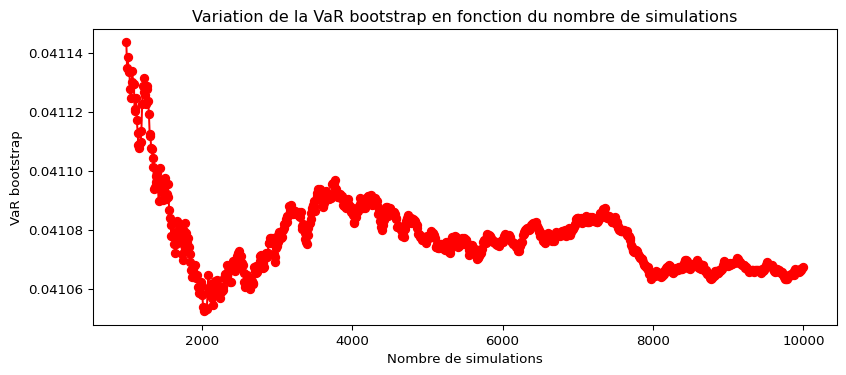

In [22]:
plt.figure(figsize=(10, 4))
plt.plot(M_values, var_bs_values, marker='o', color='red')
plt.xlabel('Nombre de simulations')
plt.ylabel('VaR bootstrap')
plt.title("Variation de la VaR bootstrap en fonction du nombre de simulations")

Pour la taille de l’echantillon bootstrap, nous allons prendre M=8000
étant donné que la courbe semble se stabiliser à partir de cette valeur.
Avec ce choix, la VaR estimé est de 4.11%% avec un intervalle de
confiance à 5% de \[4.05%, 4.09%\]. De plus, en ce qui concerne la VaR
historique, nous constatons que l’estimation est contenu dans
l’intervalle de confiance.

In [23]:
M=8000
var_bs_train, lower_ic,upper_ic = bootstrap_var(data_train, alpha=alpha, M=M)
print(f"La VaR bootstrap pour h=1j et alpha=0.99 est : {var_bs_train:.4%}")
print(f"L'intervalle de confiance est : [{lower_ic:.4%}, {upper_ic:.4%}]")

La VaR bootstrap pour h=1j et alpha=0.99 est : 4.1065%
L'intervalle de confiance est : [4.0536%, 4.0939%]

### II.2.3. Backtest

Pour l’exercice de backtest, il s’agit de : 1. Déterminer si la
proportion $p$ de violations de la VaR est cohérente avec le niveau de
confiance, i.e. égale à $1-\alpha$. Cela permet de vérifier si la mesure
de risque est bien calibrée. Pour cela, nous pouvons avoir recours à un
test de proportion ou un test de ratio de vraisemblance.

    **Unconditional coverage test** :
    Soit I la variable indicatrice de violation de la VaR, i.e. $I=1$ si la perte est supérieure à la VaR, et $I=0$ sinon. La proportion de violations de la VaR est donnée par :

    $$p = \frac{1}{n} \sum_{i=1}^{n} I_i = \frac{Z}{n}$$

    Sous H0, i.e. p=1-$\alpha$, Z $\sim$ Binomiale(n, 1-$\alpha$). En supposant que n est suffisamment grand, on peut approximer Z par une loi normale. Ainsi donc :
    $$\frac{Z - n (1-\alpha)}{\sqrt{\alpha (1-\alpha) n}} \sim \mathcal{N}(n(1-\alpha), n\alpha(1-\alpha))$$

    Sous cette hypothèse asymptotique, on peut calculer la statistique du ratio de vraisemblance suivant :
    $$LR = -2 ln \left( \frac{L(H1)}{L(H0)} \right) =-2 ln \left( 1- (1-\alpha))^{n-e}(1-\alpha)^e \right) + 2 ln \left( (1-\frac{e}{n})^{n-e} (\frac{e}{n})^e  \right)  \sim \chi^2(1)$$

    où e est le nombre de violations de la VaR. On rejette H0 si LR > $\chi^2(1-\alpha)$.

    **Test de proportion** :
    $$
    H_0 : p = p_0 = 1-\alpha \\ H_1 : p > 1-\alpha
    $$
    On peut également utiliser un test binomial pour tester si la proportion de violations de la VaR est égale à $1-\alpha$. On peut calculer la statistique du test suivant :
    $$Z = \frac{p - p_0}{\sqrt{p_0 (1-p_0) / n}} \sim \mathcal{N}(0,1)$$

    On rejette H0 si Z > $p_0+ \phi^{-1}(1-\alpha) \sqrt{p_0 (1-p_0)/n}$, où $\phi$ est la quantile de la loi normale standard.

1.  Déterminer si, lorsqu’il y en a, les violations de VaR à deux
    différents jours sont indépendantes. Cela permet si la mesure de
    risque est capable de réagir aux chocs de marché affectant la
    volatilité des rendements. Pour cela, nous utilisons un conditional
    coverage test.

    **Conditional coverage test** : y revenir

In [24]:
import scipy.stats as stats

# Objectif : implémenter une fonction calculant le nombre d'exception sur l'échantillon test
def exceptions(data, var):
    """
    Calcul du nombre d'exception
    data : les rendements logarithmiques
    var : la VaR
    """
    return np.sum(data < -var)


# Objectif : test de proportion binomiale

def binomial_test(n, p, p0 = 0.01, alpha=0.05):
    """
    Test de proportion binomiale
    H0 : p = p0
    H1 : p > p0
    n : le nombre d'essais
    p : la proportion
    alpha : le niveau de confiance
    """

    z = (p - p0) / np.sqrt(p0 * (1 - p0) / n)
    #reject_zone = p0 + stats.norm.ppf(1 - alpha) * np.sqrt(p0 * (1 - p0) / n)
    p_value = 1 - stats.norm.cdf(z)
    reject = p_value < alpha

    # Calcul des IC
    lower = p - stats.norm.ppf(1 - alpha) * np.sqrt(p * (1 - p) / n)
    upper = p + stats.norm.ppf(1 - alpha) * np.sqrt(p * (1 - p) / n)

    return p_value, reject, lower, upper

# Unconditionnal coverage test ==> to do.

In [25]:
# Backtest de la VaR historique

exceptions_test = exceptions(data_test, var_hist_train)
print(f"Le nombre d'exceptions sur l'échantillon de test est : {exceptions_test}")

print("="*80)
n = len(data_test)
p = exceptions_test / n
p_value, reject, lower,upper = binomial_test(n, p)
print(f"H0 : le nombre d'exceptions est inférieur ou égale à {1-alpha:.2%}")
print(f"IC : [{lower:.2%},{upper:.2%}]")
print(f"La p-value du test de proportion binomiale est : {p_value:.4f}")
print(f"Rejet de l'hypothèse nulle : {reject}")
print("="*80)

Le nombre d'exceptions sur l'échantillon de test est : 0
H0 : le nombre d'exceptions est inférieur ou égale à 1.00%
IC : [0.00%,0.00%]
La p-value du test de proportion binomiale est : 0.9925
Rejet de l'hypothèse nulle : False

## II.3. VaR paramétrique

### II.3.1. Validation ex-ante

Visuellement, les données ne semblent pas suivre une loi normale. En
effet, les quantiles théoriques d’une loi normale ne collent pas avec
les quantiles empiriques des rendements. Cela peut être dû à la présence
de queues épaisses observables sur l’estimation de la densité des
rendements sur l’échantillon d’apprentissage, de pics, de clusters de
volatilité que nous avons observées plus haut. De plus, le skewness est
négatif ce qui indique une asymétrie négative des rendements. Enfin, le
kurtosis est supérieur à 3, ce qui indique une distribution
leptokurtique des rendements.

Nous allons tout de même implémenter une VaR gaussienne pour voir
comment elle se comporte dans le backtest.

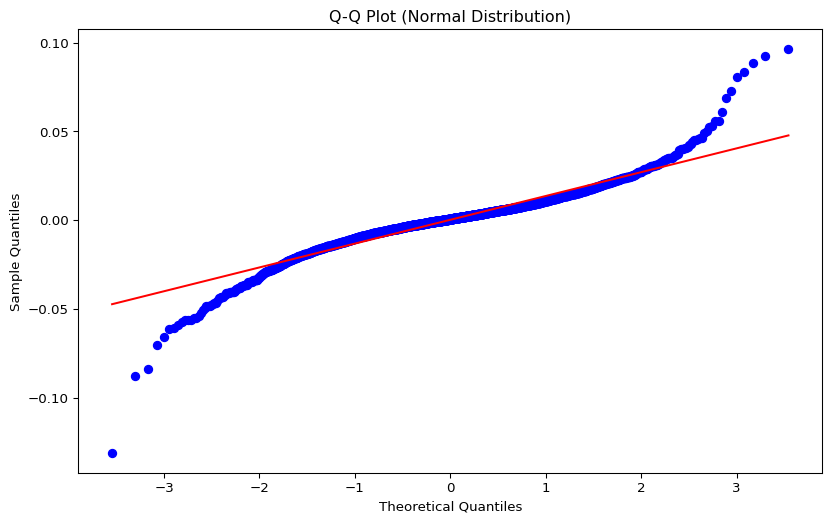

In [26]:
# Test visuel d'adéquation de la loi normale

# Créer un Q-Q plot
fig, ax = plt.subplots(figsize=(10, 6))
stats.probplot(data_train, dist="norm", plot=ax)

# Personnalisation du graphique
ax.set_title("Q-Q Plot (Normal Distribution)")
ax.set_xlabel("Theoretical Quantiles")
ax.set_ylabel("Sample Quantiles")

# Afficher le graphique
plt.show()

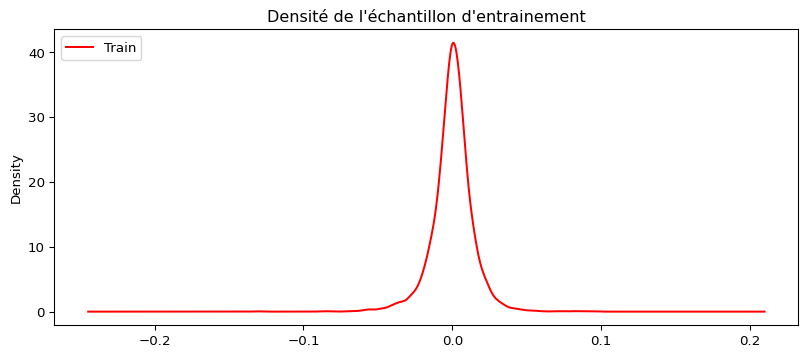

In [27]:
# Densité de l'echantillon train et l'échantillon de test

plt.figure(figsize=(10, 4))
data_train.plot(kind='kde', label='Train', color='red')
plt.legend(loc='upper left')
plt.title("Densité de l'échantillon d'entrainement")
plt.show()

In [28]:
# Skewness et kurtosis
print("="*80)
print("Skewness de l'échantillon d'entrainement : ", data_train.skew())
print("Kurtosis de l'échantillon d'entrainement : ", data_train.kurt())
print("="*80)

Skewness de l'échantillon d'entrainement :  -0.2981820421484688
Kurtosis de l'échantillon d'entrainement :  7.353960005618779

In [29]:
from scipy.stats import kstest

# Test de Kolmogorov-Smirnov
ks_stat, ks_p_value = kstest(data_train, 'norm')
print("="*80)
print("H0 : Les données suivent une loi normale")
print(f"Statistique de test : {ks_stat:.4f}")
print(f"P-value : {ks_p_value:.4f}")
print("="*80)

H0 : Les données suivent une loi normale
Statistique de test : 0.4775
P-value : 0.0000

### II.3.2. Implémentation de la VaR

#### a. Méthode scaling

In [30]:
# Objectif : écrire une fonction qui calcule la VaR gaussienne

def gaussian_var(data, alpha):
    """
    Calcul de la VaR gaussienne
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    """
    from scipy.stats import norm

    mu = np.mean(data)
    sigma = np.std(data)
    return -(mu + sigma * norm.ppf(1 - alpha))

In [31]:
var_gauss_train = gaussian_var(data_train, alpha=alpha)
print(f"La VaR gaussienne pour h=1j et alpha={alpha} est : {var_gauss_train:.4%}")
print(f"La VaR historique pour h=10j et alpha={alpha} est : {np.sqrt(10)*var_gauss_train:.4%}")

La VaR gaussienne pour h=1j et alpha=0.99 est : 3.2302%
La VaR historique pour h=10j et alpha=0.99 est : 10.2148%

#### b. Méthode de diffusion d’un actif

Pour calculer la **VaR gaussienne à 10 jours** par **méthode de
diffusion d’un actif**, nous allons suivre les étapes suivantes :

L’évolution du prix d’un actif suit un processus de type mouvement
brownien géométrique : $$
dS_t = \mu S_t dt + \sigma S_t dW_t <=> S_t = S_{t-1} e^{(\mu - \frac{1}{2} \sigma^2) + \sigma W_t}
$$ où \$ S_t\$ est le prix de l’actif à l’instant\$ t\$, \$ \$ est le
rendement moyen estimé (drift), \$ \$ est la volatilité du rendement, \$
dW_t\$ est un mouvement brownien standard.

On peut de ce fait calculer plusieurs trajectoires de rendements de
$S_0$ et $S_{10}$, puis calculer la VaR à partir de la série des
rendements \$ r\_{10j} = (S\_{10} / S\_{0}) \$ obtenus avec ces
trajectoires.

En utilisant la méthode de scaling et la méthode de diffusion, nous
obtenons sensiblement la même VaR.

In [32]:
import numpy as np

mu = np.mean(data_train)
sigma = np.std(data_train)

return_sim = []
T = 10
M = 1000
S0 = train['Close'].iloc[-1]

for i in range(M):
    S = np.zeros(T+1)
    S[0] = S0
    for t in range(1,T+1):
        Wt = np.random.normal()
        S[t] = S[t-1] * np.exp((mu - 0.5 * sigma**2) + sigma * Wt)

    return_sim.append(np.log(S[T]/S0))

var_gauss_diffusion = gaussian_var(return_sim, alpha=alpha)
print(f"La VaR gaussienne pour h=10j et alpha={alpha} est : {var_gauss_diffusion:.4%}")

La VaR gaussienne pour h=10j et alpha=0.99 est : 10.0053%

#### c. Méthode EWMA

La VaR EWMA est une méthode qui permet de calculer la VaR en
surpondérant les rendements les plus récents. Cela permet de donner plus
de poids aux rendements les plus récents, et donc de mieux capturer les
changements de volatilité. La VaR EWMA est donnée par la formule
suivante :

$$
VaR_{t+1} = \mu + \sigma \times z_{\alpha}
$$

In [33]:
# VaR la méthode EWMA (Exponential Weighting Moving Average)

def gaussian_var_ewma(data, alpha, lambda_=0.94):
    """
    Calcul de la VaR gaussienne EWMA
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    lambda_ : le paramètre de lissage
    """

    weights = np.array([(1-lambda_)*(lambda_**i) for i in range(len(data))])
    weights = weights / np.sum(weights)

    mu = np.sum(data[::-1] * weights)
    sigma = np.sqrt(np.sum(weights * (data[::-1] - mu)**2))

    return -(mu + sigma * stats.norm.ppf(1 - alpha)), mu, sigma

# y revenir

In [34]:
lambdas = [0.9, 0.95, 0.99]
alpha = 0.99
import scipy.stats as stats
for l in lambdas:
    print("="*80)
    print("Lambda : ", l)
    print("-"*15)
    var_gauss_emwa, mu, sigma = gaussian_var_ewma(data_train, alpha=alpha, lambda_=l)
    print(f"La VaR gaussienne EWMA pour h=1j et alpha={alpha} est : {var_gauss_emwa:.4%}")
    print(f"La moyenne est : {mu:.4%}")
    print(f"L'écart-type est : {sigma:.4%}")

    n_exceptions = exceptions(data_test, var_gauss_emwa)
    print(f"Le nombre d'exceptions sur l'échantillon de test est : {n_exceptions}")

Lambda :  0.9
---------------
La VaR gaussienne EWMA pour h=1j et alpha=0.99 est : 2.3751%
La moyenne est : 0.1898%
L'écart-type est : 1.1025%
Le nombre d'exceptions sur l'échantillon de test est : 5
Lambda :  0.95
---------------
La VaR gaussienne EWMA pour h=1j et alpha=0.99 est : 2.8969%
La moyenne est : 0.0735%
L'écart-type est : 1.2768%
Le nombre d'exceptions sur l'échantillon de test est : 4
Lambda :  0.99
---------------
La VaR gaussienne EWMA pour h=1j et alpha=0.99 est : 3.3511%
La moyenne est : -0.0321%
L'écart-type est : 1.4267%
Le nombre d'exceptions sur l'échantillon de test est : 1

Avec la méthode EWMA, nous observons une que la VaR diminue plus
$\lambda$ augmente. Cela est dû au fait que plus $\lambda$ est grand,
plus les rendements les plus récents sont surpondérés, et donc la
volatilité est plus faible, en raison de la fin de la période
d’apprentissage.

## II.4. VaR skew-student

### II.4.1. Validation ex-ante

In [35]:
# Ecrire une fonction permettant d’estimer les paramètres d’une loi de Skew Student par maximum de vraisemblance.

from scipy.optimize import minimize
from scipy.stats import t


def skew_student_pdf(x, mu, sigma, gamma, nu ):
    """
    Compute the Skew Student-t probability density function (PDF).
    """


    t_x = ((x - mu) * gamma / sigma) * np.sqrt((nu + 1) / (nu + ((x - mu) / sigma) ** 2))
    # PDF of the standard Student-t distribution
    pdf_t = t.pdf(x , df=nu,  loc=mu, scale=sigma)
    # CDF of the transformed Student-t distribution
    cdf_t = t.cdf(t_x, df=nu + 1,loc=0, scale=1)

    # Skew Student density function
    density = 2 * pdf_t * cdf_t

    return density


def skew_student_log_likelihood(params, data):
    """
    Calcul de la log-vraisemblance de la loi de Skew Student
    params [mu, sigma, gamma, nu]: les paramètres de la loi
    data : les rendements logarithmiques
    """
    mu, sigma, gamma, nu = params
    density = skew_student_pdf(data , mu, sigma, gamma, nu)
    # log-vraisemblance
    loglik = np.sum(np.log(density))

    return - loglik

# Optimisation des paramètres avec contraintes de positivité sur sigma et nu
def skew_student_fit(data):
    """
    Estimation des paramètres de la loi de Skew Student
    """
    # initial guess
    x0 = np.array([np.mean(data), np.std(data), 1, 4])

    # contraintes
    bounds = [(None, None), (0, None), (None, None), (None, None)]

    # optimisation
    res = minimize(skew_student_log_likelihood, x0, args=(data), bounds=bounds)

    return res.x

params = skew_student_fit(data_train)
print("="*80)
print("Les paramètres estimés de la loi de Skew Student sont : ")
print("-"*15)
print("Mu : ", params[0])
print("Sigma : ", params[1])
print("Gamma : ", params[2])
print("Nu : ", params[3])
print("="*80)


params_sstd = {
    "mu" : params[0],
    "sigma" : params[1],
    "gamma" : params[2],
    "nu" : params[3]
}

Les paramètres estimés de la loi de Skew Student sont : 
---------------
Mu :  0.0023251952411471218
Sigma :  0.008823931435233275
Gamma :  -0.23188477391476636
Nu :  2.9618199934116825

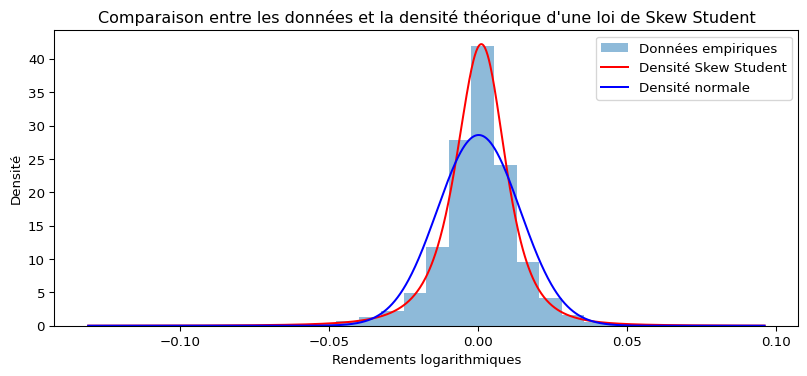

In [36]:
# Superposition de la densité théorique et des données

x_values = np.linspace(min(data_train), max(data_train), 1000)

theoretical_density = skew_student_pdf(x_values, **params_sstd)
plt.figure(figsize = (10,4))
plt.hist(data_train, bins=30, density=True, alpha=0.5, label='Données empiriques')
plt.plot(x_values, theoretical_density, label='Densité Skew Student', color='red')
# Densité normale
plt.plot(x_values, stats.norm.pdf(x_values, np.mean(data_train), np.std(data_train)), label='Densité normale', color='blue')
plt.xlabel('Rendements logarithmiques')
plt.ylabel('Densité')
plt.title("Comparaison entre les données et la densité théorique d'une loi de Skew Student")
plt.legend()

plt.show()

Le graphique ci-dessus est satisfaisant. La densité théorique de la
skew-student semble bien s’ajuster aux données. La loi skew-student de
paramètres ($\mu = 0.002, \sigma = 0.009, \gamma = -0.23, \nu = 2.96$).
Le $\mu$ est le rendement moyen, $\sigma$ est l’écart-type, $\gamma$ est
le coefficient d’asymétrie et $\nu$ est le degré de liberté. Le skewness
est négatif, ce qui indique une asymétrie négative des rendements, comme
ce qu’on a observé plus haut.

Nous allons appuyer cette validation en utilisant le QQ-plot. La
fonction quantile d’une loi skew-student n’est pas analytique. Pour ce
faire, nous allons construire la fonction de repartition de la
skew-student ainsi que la fonction quantile qui est l’inverse de cette
fonction de repartition. Nous allons ensuite comparer les quantiles
théoriques de la skew-student avec les quantiles empiriques des
rendements.

En observant le QQ-plot, on constate que les quantiles théoriques de la
skew-student collent bien avec les quantiles empiriques des rendements.
Cela confirme que la skew-student est une bonne approximation de la
distribution des rendements. Pour une validation plus rigoureuse, on
peut utiliser un test de Kolmogorov-Smirnov pour tester si les
rendements suivent une loi skew-student.

In [37]:
## Intégration de la fonction de densité
from scipy import integrate
from scipy.optimize import minimize_scalar

def integrale_SkewStudent(x,params):
    borne_inf = -np.inf
    resultat_integration, erreur = integrate.quad(lambda x: skew_student_pdf(x, **params), borne_inf, x)
    return resultat_integration

def fonc_minimize(x, alpha,params):
    value = integrale_SkewStudent(x,params)-alpha
    return abs(value)

def skew_student_quantile(alpha,mu, sigma, gamma, nu ):
    params = {
    "mu" : mu ,
    "sigma" : sigma,
    "gamma" : gamma,
    "nu" : nu
    }

    if alpha <0 or alpha >1:
        raise Exception("Veuillez entrer un niveau alpha entre 0 et 1")
    else:
        resultat_minimisation = minimize_scalar(lambda x: fonc_minimize(x, alpha,params))
        return resultat_minimisation.x

In [38]:
niveaux_quantiles = np.arange(0.001, 1, 0.001)
quantiles_empiriques = np.quantile(data_train, niveaux_quantiles)
quantiles_theoriques = [skew_student_quantile(alpha,**params_sstd) for alpha in tqdm(niveaux_quantiles)]

  0%|          | 0/999 [00:00<?, ?it/s]  0%|          | 1/999 [00:00<05:32,  3.00it/s]  0%|          | 2/999 [00:00<05:25,  3.07it/s]  0%|          | 3/999 [00:00<05:28,  3.03it/s]  0%|          | 4/999 [00:01<06:16,  2.64it/s]  1%|          | 5/999 [00:01<06:33,  2.53it/s]  1%|          | 6/999 [00:02<07:40,  2.16it/s]  1%|          | 7/999 [00:02<07:42,  2.15it/s]  1%|          | 8/999 [00:03<07:37,  2.17it/s]  1%|          | 9/999 [00:03<07:40,  2.15it/s]  1%|          | 10/999 [00:04<07:36,  2.17it/s]  1%|          | 11/999 [00:04<07:11,  2.29it/s]  1%|          | 12/999 [00:05<07:08,  2.31it/s]  1%|▏         | 13/999 [00:05<07:12,  2.28it/s]  1%|▏         | 14/999 [00:06<07:19,  2.24it/s]  2%|▏         | 15/999 [00:06<07:06,  2.31it/s]  2%|▏         | 16/999 [00:06<07:08,  2.29it/s]  2%|▏         | 17/999 [00:07<07:03,  2.32it/s]  2%|▏         | 18/999 [00:07<07:01,  2.33it/s]  2%|▏         | 19/999 [00:08<07:13,  2.26it/s]  2%|▏         | 20/999 [00:08<06:58,  2.34it/s]  2%|▏    

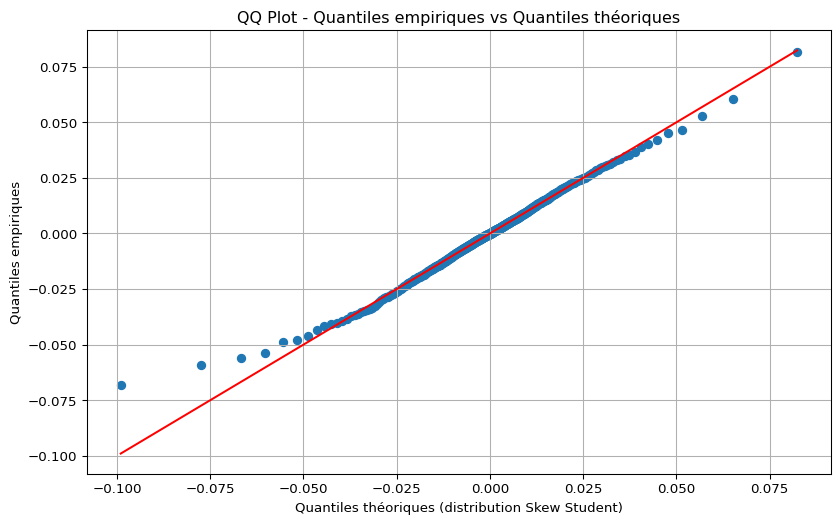

In [39]:
plt.figure(figsize=(10, 6))
plt.scatter(quantiles_theoriques, quantiles_empiriques)
plt.plot(quantiles_theoriques, quantiles_theoriques, color='red', label='Première bissectrice')
plt.title('QQ Plot - Quantiles empiriques vs Quantiles théoriques')
plt.xlabel('Quantiles théoriques (distribution Skew Student)')
plt.ylabel('Quantiles empiriques')
plt.grid(True)
plt.show()

In [40]:
# # kstest y revenir
# ks_stat, ks_p_value = kstest(data_train, skew_student_pdf, args=(**params_sstd,))

# print("="*80)
# print("H0 : Les données suivent une loi de Skew Student")
# print(f"Statistique de test : {ks_stat:.4f}")
# print(f"P-value : {ks_p_value:.4f}")
# print("="*80)
# A revoir

### II.4.2. Calcul de la VaR Skew Student

In [41]:
# Objectif : écrire une fonction qui calcule la VaR skew-student

def sstd_var_fct(alpha, params):
    """
    Calcul de la VaR skew student
    data : les rendements logarithmiques
    alpha : le niveau de confiance
    """

    return -skew_student_quantile(1-alpha, **params)

In [42]:
sstd_var = sstd_var_fct(alpha, params_sstd)
print(f"La VaR skew student pour h=1j et alpha={alpha} est : {sstd_var:.4%}")

La VaR skew student pour h=1j et alpha=0.99 est : 4.2576%

# III. Implémentation de l’ES

L’expected shortfall (ES) est une mesure de risque qui donne une
estimation de la perte moyenne au-delà du seuil de la VaR. Par exemple,
un ES à 5% sur 1 jour de 1000 euros signifie que si la perte dépasse
1000 euros, alors la perte moyenne sera de 1500 euros. L’ES est une
mesure plus robuste que la VaR, car elle prend en compte les queues de
distribution et est particulièrement utile pour évaluer les risques
extrêmes. Elle est définie comme suit :

$$ES_{\alpha}(h) = E(PnL | PnL \leq -VaR_{\alpha}(h))$$

/! La ES du cours est différente de celle ci. Elle est définie comme
suit :
$$ES_{\alpha}(h) = E(PnL - VaR | PnL \leq -VaR_{\alpha}(h)) = CTE - VaR$$

Voir ce qui est fait dans le cadre réglementaire.

In [43]:
# Expected Shortfall pour la VaR historique, bootstrap et gaussienne, et skew-student

def expected_shortfall(data, var):
    """
    Calcul de l'Expected Shortfall
    data : les rendements logarithmiques
    var : la VaR
    """
    return -data[data < -var].mean()

es_hist_train = expected_shortfall(data_train, var_hist_train)
es_bs_train = expected_shortfall(data_train, var_bs_train)
es_gauss_train = expected_shortfall(data_train, var_gauss_train)
es_sstd_train = expected_shortfall(data_train, sstd_var)

# in a df
es = pd.DataFrame({
    'Historique': [es_hist_train],
    'Bootstrap': [es_bs_train],
    'Gaussienne': [es_gauss_train],
    'Skew Student': [es_sstd_train]
})

print("="*80)
print("Expected Shortfall empirique (en %) pour h=1j")
print(round(100*es,2))
print("="*80)

Expected Shortfall empirique (en %) pour h=1j
   Historique  Bootstrap  Gaussienne  Skew Student
0        5.47       5.51        4.47          5.68

In [44]:
import scipy.stats as stats
import scipy.integrate as integrate

def expected_shortfall_theoretical(alpha, quantile_function, density_function,params):
    """
    Computes the Expected Shortfall (Conditional VaR) for a given distribution.

    Parameters:
    - alpha (float): Confidence level (e.g., 0.99 for 99%)
    - quantile_function (callable): Function to compute quantiles (e.g., skew_student_quantile)
    - params (dict): Parameters of the distribution

    Returns:
    - float: Expected Shortfall value
    """

    # Compute the Value at Risk (VaR) at level alpha
    var_alpha = quantile_function(1-alpha, **params)

    # Expected Shortfall integral
    integral_value, _ = integrate.quad(lambda x: x * density_function(x, **params), -float("inf"), var_alpha)

    # Compute Expected Shortfall
    es_alpha = -integral_value / (1 - alpha)

    return es_alpha

# Compute Expected Shortfall using the corrected function
alpha = 0.99
es_sstd_theoretical = expected_shortfall_theoretical(alpha,skew_student_quantile,skew_student_pdf, params_sstd)

params_norm = {
    "loc" : np.mean(data_train),
    "scale" : np.std(data_train)
}

es_gauss_theoretical = expected_shortfall_theoretical(alpha,stats.norm.ppf,stats.norm.pdf, params_norm)

es_theoretical = pd.DataFrame({
    'Gaussienne': [es_gauss_theoretical],
    'Skew Student': [es_sstd_theoretical]
})

print("="*80)
print("Expected Shortfall théorique (en %) pour h=1j")
print(round(100*es_theoretical,2))
print("="*80)

Expected Shortfall théorique (en %) pour h=1j
   Gaussienne  Skew Student
0         3.7          6.71

# IV.Protocole de Backtesting

L’exercice de backtesting consiste à vérifier la capacité d’adaptation
du modèle et sa viabilité en dehors de son cadre d’entraînement. Il
permet d’évaluer la performance des modèles dans le temps. Idéalement,
il faudrait le realiser quotidiennement afin d’évaluer s’il est utile ou
non de recalibrer le modèle.

Dans le cadre de TP, nous n’avons pas observé d’exceptions avec
l’utilisation de la VaR historique. Cela est probablement du à la
période d’apprentissage trop stricte. Notre modèle était donc trop
restrictif/conservateur ce qui peut témoigner de son incapacité
d’adaptation. Pour ce faire, il aurait été necessaire de le recalibrer.

Sachant que les modèles sont évalués quotidiennement, à quel moment
doit-on considérer qu’il est nécessaire de recalibrer le modèle ? Quels
indicateurs pourrait-on mettre en place pour déterminer si tout est sous
contrôle (VaR trop haute, trop basse) ou si un recalibrage est requis,
sachant que le modèle est backtesté chaque jour ?

Pour repondre à ces questions, nous proposons le protocole de backtest
ci-dessous :

-   Dans la réglementation baloise, il est demandé de tester les
    performances de la VaR sur les 250 jours suivants la date de
    réalisation du modèle. Dans ces 250 jours, on est censé observé 2 à
    3 exceptions, soit 1%. Lorsqu’il n’y a aucune exception sur cette
    période de temps, nous jugerons que le modèle est mal calibré.

-   Lorsqu’il y a des exceptions, nous pouvons comparer ces exceptions
    théoriques aux exceptions observées à l’aide d’un test de
    Kupiec/Unconditionnal coverage \[1\], une variante du test binomiale
    qui permet de tester sous l’hypothèse nulle que le taux
    d’exception(p) est égal au niveau de confiance de la VaR
    (1-$\alpha$). La statistique de test suit une loi de khi-deux à 1
    degré de liberté. Lorsque cette hypothèse est rejetée, cela signifie
    que le modèle est mal calibré. En effet, si une banque a trop
    d’exceptions, i.e. $p \geq 1 - \alpha$, cela signifie que son modèle
    sous-estime le risque, ce qui peut conduire à une exigence de
    recalibrage ou une augmentation du capital réglementaire. Si une
    banque a trop peu d’exceptions (voire 0), i.e. $p \leq 1 - \alpha$,
    cela peut indiquer que son modèle est trop conservateur, ce qui
    immobilise trop de capital inutilement.

-   Puisqu’un seul test de backtesting n’est pas suffisant\[2\] pour
    juger la qualité d’un modèle de VaR, il serait préférable de
    combiner différentes méthodes. Pour ce faire, un autre test a été
    utilisé pour juger de la necessité de recalibrage du modèle. Il
    s’agit du test de Christoffersen’s Interval Forecast/Independance
    test \[3\]. Ce test permet de vérifier si les exceptions sont
    indépendantes et donc bien réparties dans le temps. En effet, si les
    exceptions sont concentrées dans un intervalle de temps, cela peut
    indiquer que le modèle est mal calibré. Sous l’hypothèse nulle, la
    statistique de test suit asymptotiquement une loi de khi-deux à 1
    degré de liberté.

-   En couplant le test de Kupiec au test de Christoffersen \[3\], nous
    avons le test de conditional coverage mixte\[3\] qui suit une loi de
    khi-deux à 2 degrés de liberté.

Pour la mise en place de ces tests statistiques, nous avons besoin d’une
échantillon de taille suffisamment grande, i.e $N=30$. Pour ce faire,
nous ne pourrons mettre en place ce protocole qu’à partir du 30ème jour
de backtesting. Pour le backtest, nous avons fait le choix d’utiliser un
expanding window, i.e. une fenêtre d’apprentissage qui s’agrandit à
chaque période de recalibrage. Il aurait été plus pertinent de
privilégier un rolling window, i.e. une fenêtre d’apprentissage qui se
déplace à chaque période de recalibrage, pour éviter de bruiter les
données.

PROBLÈME : au bout de 30j, s’il n’y a pas d’exceptions, on ne recalibre
pas le modèle mais si au 31e jour il y a une exception, le test de
kupiec echoue=\> recalibrage. ***References***: - \[1\] Kupiec, P.
“Techniques for Verifying the Accuracy of Risk Management Models.”
Journal of Derivatives. Vol. 3, 1995, pp. 73–84. - \[2\] Haas, M. “New
Methods in Backtesting.” Financial Engineering, Research Center Caesar,
Bonn, 2001. - \[3\] Christoffersen, P. “Evaluating Interval Forecasts.”
International Economic Review. Vol. 39, 1998, pp. 841–862.

In [45]:
import numpy as np
import pandas as pd
from scipy.stats import chi2

class Backtest:
    def __init__(self, actual, forecast, alpha, alpha_test):
        self.index = actual.index
        self.actual = actual.values
        self.forecast = forecast
        self.alpha = alpha
        self.alpha_test = alpha_test

    def hit_series(self):
        """ Returns a series of 1s (VaR breaches) and 0s (no breach) """
        return (self.actual < - self.forecast).astype(int)
    
    def lr_bt(self):
        """ Back-test protocol """
        hits = self.hit_series()  # Série des violations de la VaR (1 si violation, 0 sinon)
        transitions = hits[1:] - hits[:-1]  # Différences entre valeurs successives (1 si passage de 0 à 1, -1 si passage de 1 à 0)

        # Transition counts
        n01 = np.sum(transitions == 1)  # 0 -> 1
        n10 = np.sum(transitions == -1) # 1 -> 0
        n11 = np.sum((transitions == 0) & (hits[1:] == 1)) # 1 -> 1
        n00 = np.sum((transitions == 0) & (hits[1:] == 0)) # 0 -> 0
        
        # Number of observations in each state
        n0, n1 = n01 + n00, n10 + n11
        total_n = n0 + n1
        
        # Probability estimates
        p01 = n01 / (n00 + n01) if (n00 + n01) > 0 else 0
        p11 = n11 / (n11 + n10) if (n11 + n10) > 0 else 0
        p = n1 / total_n if total_n > 0 else 0
        
        if n1 > 0:
            #

            # Unconditional Coverage Test/Kupiec
            uc_h0 = n0 * np.log(1 - self.alpha) + n1 * np.log(self.alpha)
            uc_h1 = n0 * np.log(1 - p) + n1 * np.log(p)
            uc_stat = -2 * (uc_h0 - uc_h1)
            # uc_critical_val = chi2.ppf(self.alpha_test, 1)
            uc_pval = 1 - chi2.cdf(uc_stat, 1)
            
            # Independence Test/Christoffersen
            ind_h0 = (n00 + n01) * np.log(1 - p) + (n01 + n11) * np.log(p)
            ind_h1 = 0
            if p01 > 0: ind_h1 += n01 * np.log(p01)
            if (1 - p01) > 0: ind_h1 += n00 * np.log(1 - p01)
            if p11 > 0: ind_h1 += n11 * np.log(p11)
            if (1 - p11) > 0: ind_h1 += n10 * np.log(1 - p11)
            ind_stat = -2 * (ind_h0 - ind_h1)
            # ind_critical_val = chi2.ppf(self.alpha_test, 1)
            ind_pval = 1 - chi2.cdf(ind_stat, 1)
            
            # Conditional Coverage Test/ Christoffersen & Kupiec mixture
            cc_stat = uc_stat + ind_stat
            # cc_critical_val = chi2.ppf(self.alpha_test, 2)
            cc_pval = 1 - chi2.cdf(cc_stat, 2)
            
            # Store results in a DataFrame
            df = pd.DataFrame({
                "Statistic": [uc_stat, cc_stat, ind_stat],
                # "Critical Value": [uc_critical_val, ind_critical_val, cc_critical_val],
                "p-value": [uc_pval, cc_pval, ind_pval]
            }, index=["Unconditional", "Conditional","Independence"])

            binomial_test = stats.binomtest(n1, total_n, 1-self.alpha, alternative='two-sided')
            df.loc["Binomial"] = [binomial_test.statistic, binomial_test.pvalue]
        else:
            df = pd.DataFrame(np.nan, index=["Unconditional", "Conditional", "Independence"], columns=["Statistic", "p-value"])
            binomial_test = stats.binomtest(n1, total_n, 1-self.alpha, alternative='two-sided')
            df.loc["Binomial"] = [binomial_test.statistic, binomial_test.pvalue]
        
        
        return df

In [46]:
def daily_backtest(actual, forecast, alpha=0.99, alpha_test = 0.95,min_days=30, max_days=250):
    """ Runs a growing backtest daily, starting at min_days up to max_days """
    recalibration_needed = False
    end_test = min(max_days,len(actual))
    for end in range(min_days, end_test +1):
        data_to_test = actual[:end]
        var_to_test = forecast
        if len(data_to_test) < 30:
            continue
        
        bt = Backtest(actual=data_to_test, forecast=var_to_test, alpha=alpha, alpha_test=alpha_test)
        result = bt.lr_bt()
        
        nb_exceptions = bt.hit_series().sum()
        
        # res=bootstrap((data_to_test,), statistic=lambda x: exceptions(x, var_to_test)/len(x), method='percentile', n_resamples=1000)
        # ci_lower, ci_upper = res.confidence_interval

        # if ci_lower <= 1-alpha <= ci_upper:
        #     print(f"Recalibration needed at {end} days: The conditional test failed.")
        #     recalibration_needed = True
        #     return recalibration_needed, end

        # if "conditional" in result.index and result.loc["Independence", "p-value"] < 0.05:
        #     print(f"Recalibration needed at {end} days: The Independence test failed.")
        #     recalibration_needed = True
        #     return recalibration_needed, end
        # failed_tests = result.iloc[2:][result.iloc[2:]["p-value"] < 0.05].index.tolist()
        failed_tests = result[result["p-value"] < 0.05].index.tolist()

        if failed_tests:
            print(f"Recalibration needed at {end} days: The following tests failed: {', '.join(failed_tests)}")
            recalibration_needed = True
            return recalibration_needed, end
            
        if end == max_days and nb_exceptions == 0:
            print(f"Recalibration needed at {end} days: No exceptions observed in the test window.")
            recalibration_needed = True
            return recalibration_needed, end
    
    if not recalibration_needed:
        print("No recalibration needed in the tested period.")

In [47]:
def iterative_backtest(data_train, data_test, var_model, alpha):
    """ Runs an iterative backtest with recalibration """
    data_train = data_train.copy()
    data_test = data_test.copy()

    var_result = var_model(data_train, alpha=alpha)
    var_to_test = var_result[0] if isinstance(var_result, (list, tuple)) else var_result 
    
    recalibration_points = [0]
    vars_stored = [var_to_test]
    
    while len(data_test) > 0 and len(data_test) >= 250:
        print("="*80)
        print(f"Old VaR to test: {var_to_test:.4%}")

        # Run daily backtest correctly
        res_backtest, index = daily_backtest(data_test, var_to_test, alpha=alpha, alpha_test=0.95, min_days=30, max_days=250)

        # Find the index of recalibration
        if res_backtest:
            print(len(data_test))
            recalibration_points.append(index)

            # Expand training data and shrink test data
            data_train = pd.concat([data_train, data_test.iloc[:index,]])
            data_test = data_test.iloc[index:,]
            var_result = var_model(data_train, alpha=alpha)
            var_to_test = var_result[0] if isinstance(var_result, (list, tuple)) else var_result 
            vars_stored.append(var_to_test)

            print(f"New VaR to test: {var_to_test:.4%}")
        else:
            print("No recalibration needed.")
            break

    return recalibration_points, vars_stored

# Execute iterative backtest
recalibration_points, vars_stored = iterative_backtest(data_train, data_test, gaussian_var_ewma, alpha=alpha)

Old VaR to test: 2.7763%
Recalibration needed at 103 days: The following tests failed: Unconditional, Conditional
586
New VaR to test: 2.5925%
Old VaR to test: 2.5925%
Recalibration needed at 61 days: The following tests failed: Unconditional, Conditional
483
New VaR to test: 2.6675%
Old VaR to test: 2.6675%
Recalibration needed at 30 days: The following tests failed: Unconditional, Conditional
422
New VaR to test: 1.8885%
Old VaR to test: 1.8885%
Recalibration needed at 50 days: The following tests failed: Unconditional, Conditional
392
New VaR to test: 2.5369%
Old VaR to test: 2.5369%
Recalibration needed at 240 days: The following tests failed: Unconditional, Conditional
342
New VaR to test: 2.7075%

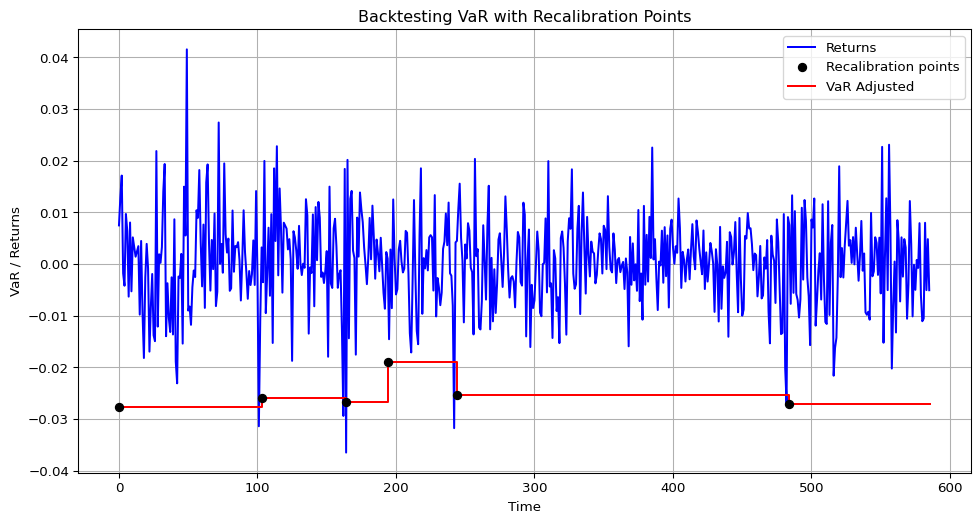

In [48]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(12, 6))
data_test.reset_index(drop=True, inplace=True)
plt.plot(data_test, label="Returns", color='blue')
recab = np.cumsum(np.array(recalibration_points))
vars_stored_neg = -np.array(vars_stored)

plt.scatter(recab, vars_stored_neg, color='black', label="Recalibration points", zorder=3)
if len(recab) > 0:
    plt.step(recab, vars_stored_neg, where='post', color='red', linestyle='solid', label="VaR Adjusted")
    plt.hlines(vars_stored_neg[-1], xmin=recab[-1], xmax=len(data_test), color='red', linestyle='solid')

plt.xlabel("Time")
plt.ylabel("VaR / Returns")
plt.title("Backtesting VaR with Recalibration Points")
plt.legend()
plt.grid(True)

plt.show()